# Exercise 12: Image Augmentation

https://docs.opencv.org/4.6.0/da/d6e/tutorial_py_geometric_transformations.html

In this exercise you will:
- Learn to apply different geometric transformations to images (e.g. scaling, translation, rotation).
- Use the OpenCV function [cv.getPerspectiveTransform()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae).

As a first step, let's import the python modules we need.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Transformations

OpenCV provides two transformation functions, [cv.warpAffine()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983) and [cv.warpPerspective()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87), with which you can perform all kinds of transformations. The `cv.warpAffine()` function takes a $2x3$ transformation matrix as input, while the `cv.warpPerspective()` function takes a $3x3$ transformation matrix as input.

`cv.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) -> dst`
- `src` is the source (input) image.
- `M` is the $2x3$ transformation matrix.
- `dsize` is the size $(width, height)$ of the output image (in pixels).
- `dst` is the destination (output) image.
- `flags` is a combination of [interpolation methods](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121) (`cv.INTER_LINEAR` as default) and the optional flag `cv.WARP_INVERSE_MAP` which means that `M` is the inverse transformation.
- `borderMode` is the pixel extrapolation method, i.e. [border type](https://docs.opencv.org/4.6.0/d2/de8/group__core__array.html#ga209f2f4869e304c82d07739337eae7c5) (with `cv.BORDER_CONSTANT` as default).
- `borderValue` is the value used (default = 0) when `bordeMode = cv.BORDER_CONSTANT`.

`cv.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]]) -> dst`
- Has the exact same parameters as `cv.warpAffine()` above, except `M` is a $3x3$ matrix, with the additional bottom row $\begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$.

If the $2x3$ transformation matrix `M` for `cv.warpAffine()` is defined as the left matrix below, then the equivalent $3x3$ transformation matrix `M` for `cv.warpPerspective()` is defined as the right matrix below:

$$
M_{2x3} =
\begin{bmatrix}
m_{11} & m_{12} & m_{13}\\
m_{21} & m_{22} & m_{23}
\end{bmatrix}

\quad \iff \quad

M_{3x3} =
\begin{bmatrix}
m_{11} & m_{12} & m_{13}\\
m_{21} & m_{22} & m_{23}\\
0 & 0 & 1
\end{bmatrix}
$$

**Note** that you need to convert the int matrix to a float matrix before using it with `cv.warpAffine()` and `cv.warpPerspective()`, e.g. `M = np.float32([[Sx, 0, 0],[0, Sy, 0]])`.

We will see how to use these two functions together with different matrices to apply different transformations to images.

### Scaling (Zooming)

Scaling is just resizing an image. We can scale an image by a factor of $S_x$ in the $x$ (horizontal) direction, and/or by a factor of $S_y$ in the $y$ (vertical) direction. If the scaling factor is:
- $<1$ : the image will be shrinked (where the scaling factor is $>0$).
- $=1$ : the image will keep its original size.
- $>1$ : the image will be enlarged.

For example, if you set $S_x = S_y = 2$, the image would double its size in both directions, and if you set $S_x = S_y = 0.5$, the image would reduce its size by half in both directions.

If you know the scaling factors $S_x$ and $S_y$, you can create the transformation matrix $M_A$ (for `cv.warpAffine()`) and $M_P$ (for `cv.warpPerspective()`) as follows:

$$
M_A =
\begin{bmatrix}
S_x & 0 & 0\\
0 & S_y & 0
\end{bmatrix}

\quad

M_P =
\begin{bmatrix}
S_x & 0 & 0\\
0 & S_y & 0\\
0 & 0 & 1
\end{bmatrix}
$$

Let's look at an example using both methods.

(342, 548, 3)
(342, 548, 3)


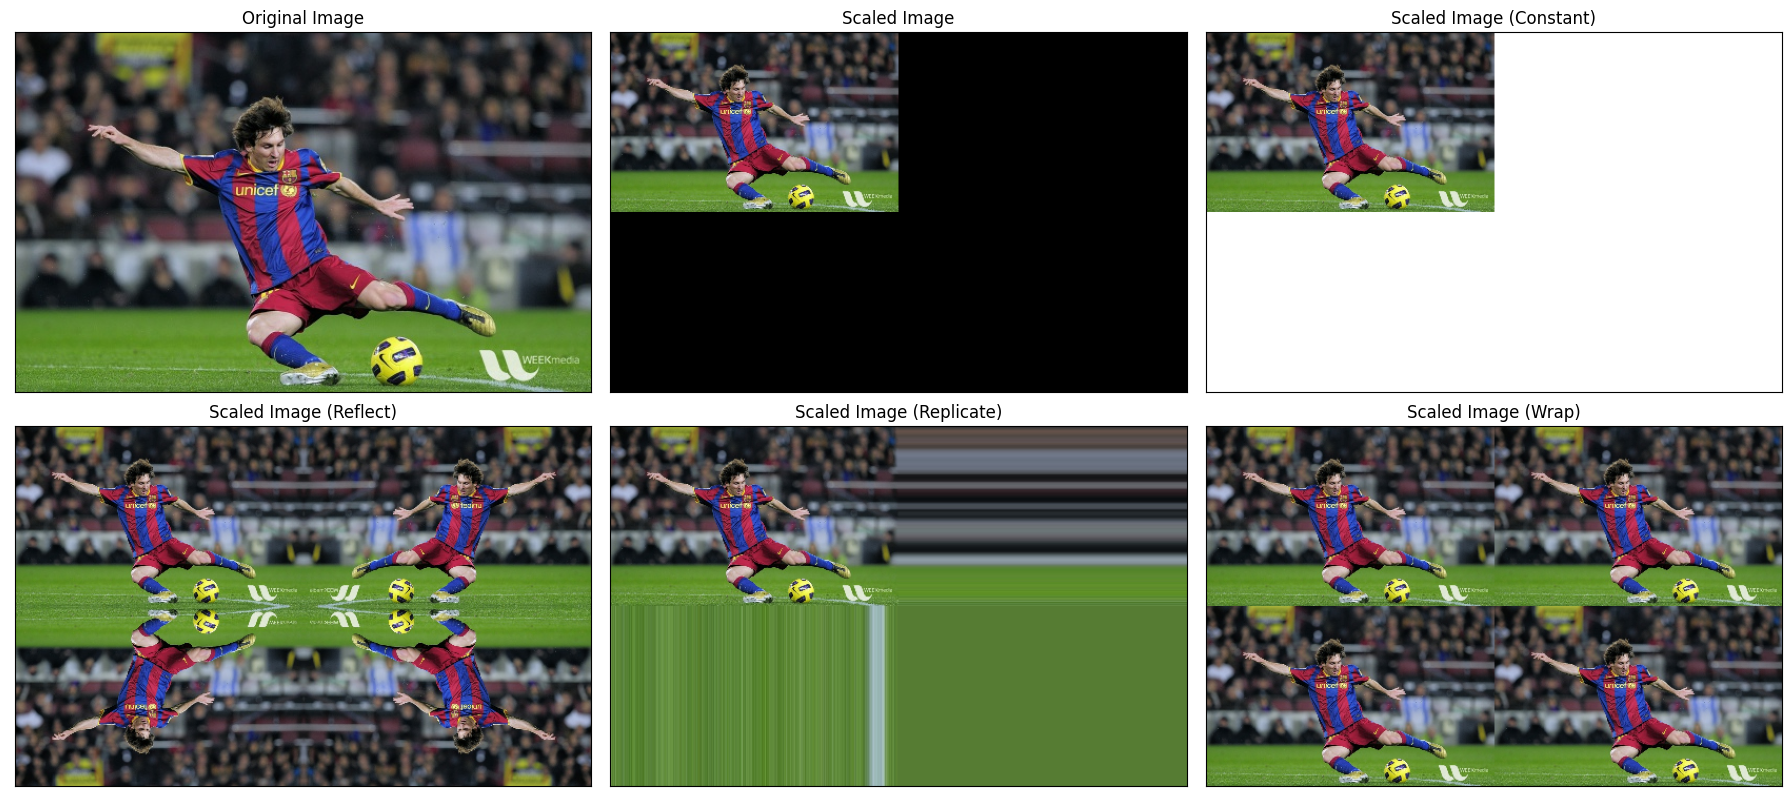

In [2]:
# Read in an image
img = cv.imread('../data/messi5.jpg')

# Get the number of rows and columns in the original image
rows, cols = img.shape[0:2]

# Define the scale factors Sx and Sy:
# <1 : shrink (>0)
# <1 : keep current scale
# >1 : enlarge
Sx = 0.5
Sy = 0.5

# Create a 2x3 scale matrix
# (to be used with 'cv.warpAffine()').
M_2x3 = np.float32([
    [Sx,  0, 0],
    [ 0, Sy, 0]
])

# Create a 3x3 scale matrix
# (to be used with 'cv.warpPerspective()').
M_3x3 = np.float32([
    [Sx,  0, 0],
    [ 0, Sy, 0],
    [ 0,  0, 1]
])

# Let's also set the size we want for the scaled image.
# There are two common ways to do this:
# 1. If we use the same size (cols, rows) for the transformed image as for the original image:
# - Sx=Sy=2 will create a "zoomed in" image of the top-left half of the image.
# - Sx=Sy=0.5 will create a "zoomed out" image replacing "missing" pixels according to the 'borderMode' below.
# 2. If we scale the size (cols*Sx, rows*Sy) of the transformed image using the same scale factors as in the transform:
# - Sx=Sy=2 will create a similar image as the original, but with the number of pixels doubled in both directions.
# - Sx=Sy=0.5 will create a similar image as the original, but with the number of pixels cut in half in both directions.
img_scaled_size = (cols, rows)
#img_scaled_size = (int(cols*Sx), int(rows*Sy))  # try uncommenting this to see the effects described in (2)

# Transform the image using the scale matrix.
# Here we are using various 'borderMode' settings to see how
# they affect the way "added/deleted" pixels are "filled in".
# Also notice we are setting the size of the transformed image as defined above.
img_scaled = cv.warpAffine(img, M_2x3, img_scaled_size)
img_scaled_constant = cv.warpAffine(img, M_2x3, img_scaled_size, borderMode=cv.BORDER_CONSTANT, borderValue=[255,255,255])
img_scaled_reflect = cv.warpAffine(img, M_2x3, img_scaled_size, borderMode=cv.BORDER_REFLECT)
img_scaled_replicate = cv.warpAffine(img, M_2x3, img_scaled_size, borderMode=cv.BORDER_REPLICATE)
img_scaled_wrap = cv.warpAffine(img, M_2x3, img_scaled_size, borderMode=cv.BORDER_WRAP)

# The parameters are the same for 'cv.warpPerspective()', but uses the 3x3 matrix.
#img_scaled = cv.warpPerspective(img, M_3x3, img_scaled_size)
#img_scaled_constant = cv.warpPerspective(img, M_3x3, img_scaled_size, borderMode=cv.BORDER_CONSTANT, borderValue=[255,255,255])
#img_scaled_reflect = cv.warpPerspective(img, M_3x3, img_scaled_size, borderMode=cv.BORDER_REFLECT)
#img_scaled_replicate = cv.warpPerspective(img, M_3x3, img_scaled_size, borderMode=cv.BORDER_REPLICATE)
#img_scaled_wrap = cv.warpPerspective(img, M_3x3, img_scaled_size, borderMode=cv.BORDER_WRAP)

# Print the size of the original image and the scaled image
print(img.shape)
print(img_scaled.shape)

# Plot the original image and the scaled image
plt.figure(figsize=(18,12))

plt.subplot(331), plt.imshow(img[:,:,::-1]),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(332), plt.imshow(img_scaled[:,:,::-1]),
plt.title("Scaled Image"), plt.xticks([]), plt.yticks([])

plt.subplot(333), plt.imshow(img_scaled_constant[:,:,::-1]),
plt.title("Scaled Image (Constant)"), plt.xticks([]), plt.yticks([])

plt.subplot(334), plt.imshow(img_scaled_reflect[:,:,::-1]),
plt.title("Scaled Image (Reflect)"), plt.xticks([]), plt.yticks([])

plt.subplot(335), plt.imshow(img_scaled_replicate[:,:,::-1]),
plt.title("Scaled Image (Replicate)"), plt.xticks([]), plt.yticks([])

plt.subplot(336), plt.imshow(img_scaled_wrap[:,:,::-1]),
plt.title("Scaled Image (Wrap)"), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

OpenCV has another function [cv.resize()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d) for resizing (scaling) an image without defining a transformation matrix. It gives the exact same results as the code above, when we set `img_scaled_size = (int(cols*Sx), int(rows*Sy))`.

The size of the image can be specified manually, or you can specify the scaling factor. Different interpolation methods are used (to account for added/deleted pixels). Preferable interpolation methods are [cv.INTER_AREA](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#gga5bb5a1fea74ea38e1a5445ca803ff121acf959dca2480cc694ca016b81b442ceb) for shrinking an image, and [cv.INTER_CUBIC](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#gga5bb5a1fea74ea38e1a5445ca803ff121a55e404e7fa9684af79fe9827f36a5dc1) (slow) or [cv.INTER_LINEAR](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#gga5bb5a1fea74ea38e1a5445ca803ff121ac97d8e4880d8b5d509e96825c7522deb) for enlarging an image. By default, the interpolation method `cv.INTER_LINEAR` is used for all resizing purposes.

`resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) -> dst`
- `src` is the input image.
- `dsize` is the size $(width, height)$ of `dst` (if 0, it's computed as $( round(fx*src.cols), round(fy*src.rows) )$).
- `dst` is the destination image (i.e. the resized image).
- `fx` is the scale factor along the horizontal axis (if, 0 it's computed as $(double) dsize.width/src.cols$.
- `fy` is the scale factor along the vertical axis (if, 0 it's computed as $(double) dsize.height/src.rows$.
- `interpolation` is the interpolation method, e.g. `cv.INTER_LINEAR` (default).

Either `dsize` or both `fx` and `fy` must be non-zero. Therefore, an image can be resized using either of the following methods:

1. Determine the new size by setting `dsize` = $(width, height)$, and skip `fx` and `fy` (they are set to 0 as default).
2. Determine how much to scale the input image in the x and y directions by setting `fx` and `fy`, and set `dize` to `None`.

Let's look at an example using both methods to double the size of an image in both directions.

The original image size is: (342, 548) 
The resized image size (method 1) is: (684, 1096) 
The resized image size (method 2) is: (684, 1096) 


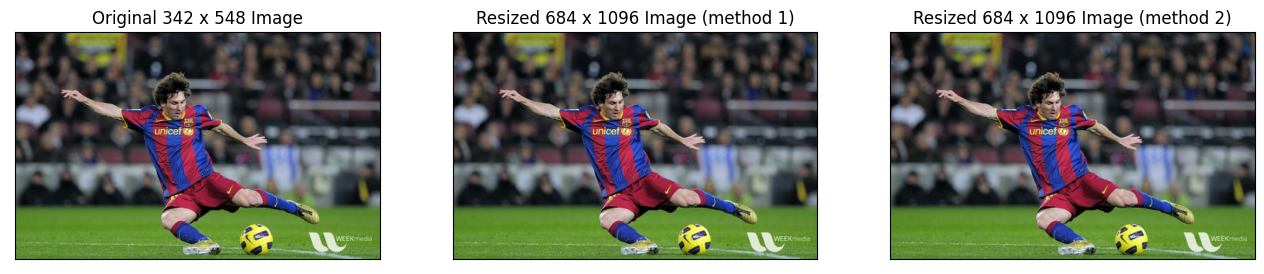

In [3]:
# Read in an image
img = cv.imread('../data/messi5.jpg')

# Scale the image by a factor of 2 in both the x and y directions
Sx = 2
Sy = 2

# Resize the image
img_resized_1 = cv.resize(img, None, fx=Sx, fy=Sy, interpolation = cv.INTER_CUBIC)

# We can also resize the image explicitly by supplying
# the number of pixels in the x and y directions
height, width = img.shape[:2]
img_resized_2 = cv.resize(img, (Sx*width, Sy*height), interpolation = cv.INTER_CUBIC)

# Print the size of the original image and the two resized images
print(f'The original image size is: {img.shape[:2]} ')
print(f'The resized image size (method 1) is: {img_resized_1.shape[:2]} ')
print(f'The resized image size (method 2) is: {img_resized_2.shape[:2]} ')

# Plot the original image and the resized image
plt.figure(figsize=(16,16))

plt.subplot(131), plt.imshow(img[:,:,::-1]),
plt.title(f"Original {img.shape[0]} x {img.shape[1]} Image"), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(img_resized_1[:,:,::-1]),
plt.title(f"Resized {img_resized_1.shape[0]} x {img_resized_1.shape[1]} Image (method 1)"), plt.xticks([]), plt.yticks([])

plt.subplot(133), plt.imshow(img_resized_2[:,:,::-1]),
plt.title(f"Resized {img_resized_2.shape[0]} x {img_resized_2.shape[1]} Image (method 2)"), plt.xticks([]), plt.yticks([])

plt.show()

### Translation

Translation is the shifting of an object's location. If you know the shift $T_x$ in the $x$ direction, and the shift $T_y$ in the $y$ direction, you can create the transformation matrix $M_A$ (for `cv.warpAffine()`) and $M_P$ (for `cv.warpPerspective()`) as follows:

$$
M_A =
\begin{bmatrix}
1 & 0 & T_x\\
0 & 1 & T_y
\end{bmatrix}

\quad

M_P =
\begin{bmatrix}
1 & 0 & T_x\\
0 & 1 & T_y\\
0 & 0 & 1
\end{bmatrix}
$$

Let's look at an example with $T_x = 100$ and $T_y = 50$, using the same size for the transformed image as the original image.

We will only use the $2x3$ matrix with `cv.warpAffine()` in the example, but we can also use the $3x3$ matrix with `cv.warpPerspective()`.

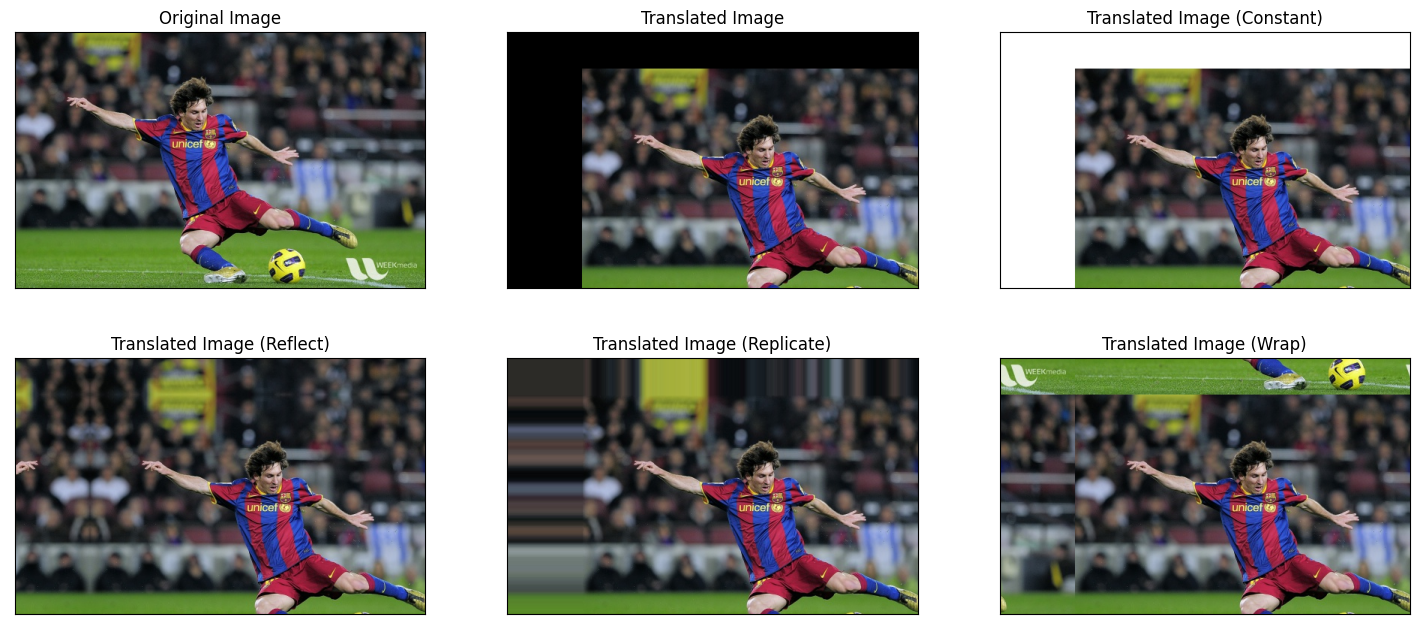

In [4]:
# Read in an image
img = cv.imread('../data/messi5.jpg')

# Get the number of rows and columns in the image
rows, cols = img.shape[0:2]

# Define the shift Tx and Ty.
Tx = 100 # 100 pixels to the right
Ty = 50  # 50 pixels down

# Create a translation matrix
M = np.float32([
    [1, 0, Tx],
    [0, 1, Ty]
])

# Transform the image using the translation matrix
# (use various 'borderModes' for comparison)
img_translated = cv.warpAffine(img, M, (cols,rows))
img_translated_constant = cv.warpAffine(img, M, (cols,rows), borderMode=cv.BORDER_CONSTANT, borderValue=[255,255,255])
img_translated_reflect = cv.warpAffine(img, M, (cols,rows), borderMode=cv.BORDER_REFLECT)
img_translated_replicate = cv.warpAffine(img, M, (cols,rows), borderMode=cv.BORDER_REPLICATE)
img_translated_wrap = cv.warpAffine(img, M, (cols,rows), borderMode=cv.BORDER_WRAP)

# Plot the original image and the translated image
plt.figure(figsize=(18,12))

plt.subplot(331), plt.imshow(img[:,:,::-1]),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(332), plt.imshow(img_translated[:,:,::-1]),
plt.title("Translated Image"), plt.xticks([]), plt.yticks([])

plt.subplot(333), plt.imshow(img_translated_constant[:,:,::-1]),
plt.title("Translated Image (Constant)"), plt.xticks([]), plt.yticks([])

plt.subplot(334), plt.imshow(img_translated_reflect[:,:,::-1]),
plt.title("Translated Image (Reflect)"), plt.xticks([]), plt.yticks([])

plt.subplot(335), plt.imshow(img_translated_replicate[:,:,::-1]),
plt.title("Translated Image (Replicate)"), plt.xticks([]), plt.yticks([])

plt.subplot(336), plt.imshow(img_translated_wrap[:,:,::-1]),
plt.title("Translated Image (Wrap)"), plt.xticks([]), plt.yticks([])

plt.show()

### Rotation

Rotation of an image by an angle of $\theta$ radians (counter clockwise if $\theta > 0$) around the coordinate $(0,0)$, using a so called *left-handed coordinate system* that OpenCV uses, is achieved using a transformation matrix $M_A$ (for `cv.warpAffine()`) and $M_P$ (for `cv.warpPerspective()`) as follows:

$$
M_A =
\begin{bmatrix}
cos \theta & sin \theta & 0\\
-sin \theta & cos \theta & 0
\end{bmatrix}

\quad

M_P =
\begin{bmatrix}
cos \theta & sin \theta & 0\\
-sin \theta & cos \theta & 0\\
0 & 0 & 1
\end{bmatrix}
$$

But, OpenCV provides a scaled rotation with adjustable center of rotation, so that you can rotate at any location you prefer. The modified transformation matrix is given by:

$$
M =
\begin{bmatrix}
\alpha & \beta & (1 - \alpha) \cdot center_x - \beta \cdot center_y \\
- \beta & \alpha & \beta \cdot center_x + (1 - \alpha) \cdot center_y
\end{bmatrix}
$$

where:

$$
\alpha = scale \cdot cos \theta \\
\beta = scale \cdot sin \theta
$$

To obtain this transformation matrix, you can use the OpenCV function [cv.getRotationMatrix2D()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326).

`getRotationMatrix2D(center, angle, scale) -> retval`
- `center` is the center of the rotation in the source image $(x,y)$.
- `angle` is the (counter-clockwise) rotation angle in degrees (origin at the top left corner).
- `scale` is the scale factor.

The function's return value `retval` contains the rotation matrix.

We can accomplish the same thing, i.e. rotating the image around its center, using three steps:

1. Translating the image so that its center is at the origin (top left corner).
2. Rotating the image around the origin (now the center of the image).
3. Translating the image back again to its original position.

We can combine steps 1-3 (where $T_x=\frac{\#cols}{2}$ and $T_y=\frac{\#rows}{2}$) using matrix multiplication of the $3x3$ matrices from right-to-left, i.e.:

$$
M_P =
\begin{bmatrix}
1 & 0 & T_x\\
0 & 1 & T_y\\
0 & 0 & 1\\
\end{bmatrix}

*

\left(

\begin{bmatrix}
cos \theta & sin \theta & 0\\
-sin \theta & cos \theta & 0\\
0 & 0 & 1\\
\end{bmatrix}

*

\begin{bmatrix}
1 & 0 & -T_x\\
0 & 1 & -T_y\\
0 & 0 & 1\\
\end{bmatrix}

\right)

=

\begin{bmatrix}
cos \theta & sin \theta & -T_xcos \theta-T_ysin \theta +T_x\\
-sin \theta & cos \theta & T_xsin \theta-T_ycos \theta +T_y\\
0 & 0 & 1\\
\end{bmatrix}
$$

We could also add scaling by including a $3x3$ scaling matrix as the rightmost term in the matrix multiplication above (left multiplied by the translation matrix with the $-T_x$ and $-T_y$ terms).

The equivalent $2x3$ matrix would be:
$$
M_A =
\begin{bmatrix}
cos \theta & sin \theta & -T_xcos \theta-T_ysin \theta +T_x\\
-sin \theta & cos \theta & T_xsin \theta-T_ycos \theta +T_y
\end{bmatrix}
 =
\begin{bmatrix}
cos \theta & sin \theta & (1-cos \theta)T_x - T_ysin \theta\\
-sin \theta & cos \theta & T_xsin \theta + (1-cos \theta)T_y
\end{bmatrix}
$$

Let's look at an example that rotates the image 45 degrees (counter-clockwise) around the image's center without any scaling.

We will only use the $2x3$ matrix with `cv.warpAffine()` in the example, but we can also use the $3x3$ matrix with `cv.warpPerspective()`.

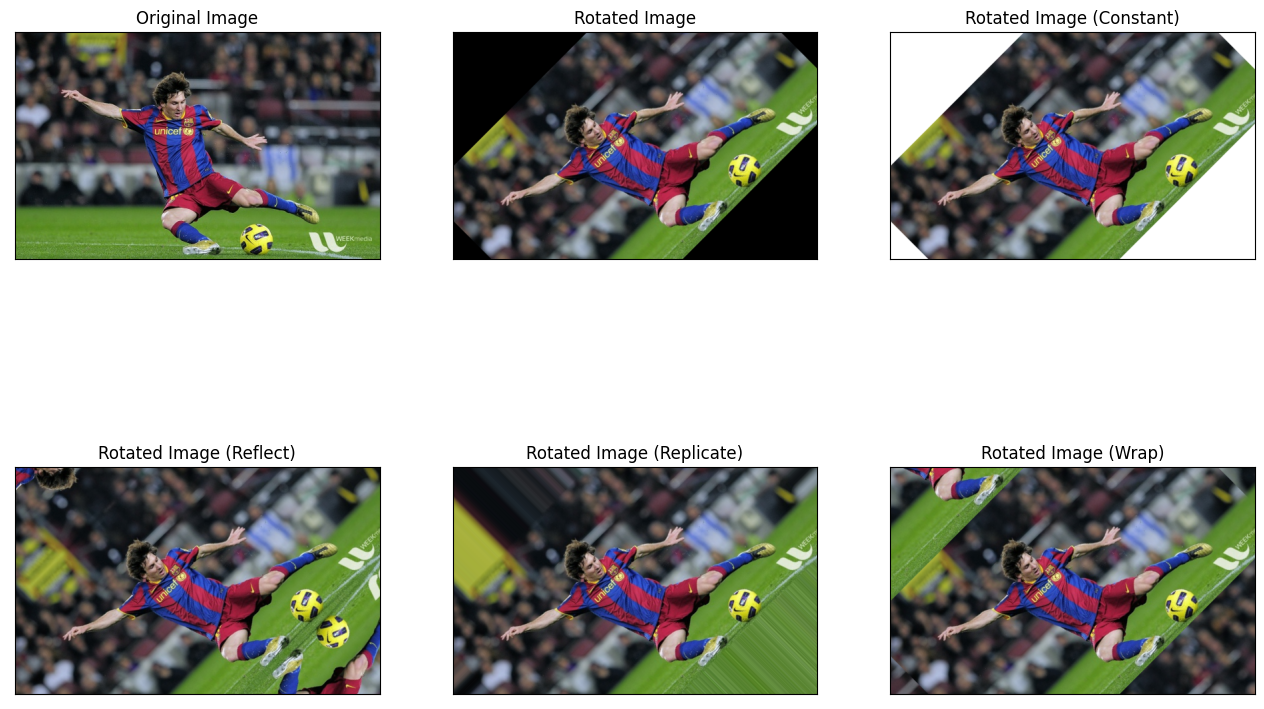

In [5]:
# Read in an image
img = cv.imread('../data/messi5.jpg')

# Get the number of rows and columns in the image
rows, cols = img.shape[0:2]

# Define Tx and Ty as half the image's
# width and height respectively
Tx = (cols-1) / 2.0
Ty = (rows-1) / 2.0

# Define a 45 degreee angle of
# rotation and convert to radians.
theta_degrees = 45
theta_radians = theta_degrees * np.pi/180.0

# Create a rotation matrix using 'cv.getRotationMatrix2D()'
# that rotates the image:
# - around the image center
# - by 45 degrees (counter-clockwise)
# - without any scaling (scale = 1).
M = cv.getRotationMatrix2D((Tx,Ty), 45, 1)


# Let's also define the rotation matrix ourselves:

# 1. Create the first translation matrix (translates the image
# so that its center is at the origin, i.e. top left corner)
Mt1 = np.float32([
    [1, 0, -Tx],
    [0, 1, -Ty],
    [0, 0, 1]
])

# 2. Create rotation matrix (rotates the image around the origin,
# i.e. top left corner, at which the image's center now resides)
Mr = np.float32([
    [np.cos(theta_radians), np.sin(theta_radians), 0],
    [-np.sin(theta_radians), np.cos(theta_radians), 0],
    [0, 0, 1]
])

# 3. Create second translation matrix (translates
# the image back to its original position)
Mt2 = np.float32([
    [1, 0, Tx],
    [0, 1, Ty],
    [0, 0, 1]
])

# Use matrix multiplication to calculate the final 3x3 transformation matrix
Mp = Mt2.dot(Mr.dot(Mt1))

# Convert the 3x3 transformation matrix to a 2x3 transformation matrix
# i.e. simply discard the bottom row [0 0 1].
Ma = Mp.copy()
Ma = Ma[:2,:]

# Transform the image with the transformation matrix 
# (use various 'borderModes' for comparison)
# Let's use our own transformation matrix for the first example and OpenCV's 'cv.getRotationMatrix2D()' for the others, so we see that everything is working.

#img_rotated = cv.warpAffine(img, M, (cols,rows))
img_rotated = cv.warpAffine(img, Ma, (cols,rows))

img_rotated_constant = cv.warpAffine(img, M, (cols,rows), borderMode=cv.BORDER_CONSTANT,
                                     borderValue=[255,255,255])
img_rotated_reflect = cv.warpAffine(img, M, (cols,rows), borderMode=cv.BORDER_REFLECT)
img_rotated_replicate = cv.warpAffine(img, M, (cols,rows), borderMode=cv.BORDER_REPLICATE)
img_rotated_wrap = cv.warpAffine(img, M, (cols,rows), borderMode=cv.BORDER_WRAP)

# Plot the original image and the rotated image
plt.figure(figsize=(16,16))

plt.subplot(331), plt.imshow(img[:,:,::-1]),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(332), plt.imshow(img_rotated[:,:,::-1]),
plt.title("Rotated Image"), plt.xticks([]), plt.yticks([])

plt.subplot(333), plt.imshow(img_rotated_constant[:,:,::-1]),
plt.title("Rotated Image (Constant)"), plt.xticks([]), plt.yticks([])

plt.subplot(334), plt.imshow(img_rotated_reflect[:,:,::-1]),
plt.title("Rotated Image (Reflect)"), plt.xticks([]), plt.yticks([])

plt.subplot(335), plt.imshow(img_rotated_replicate[:,:,::-1]),
plt.title("Rotated Image (Replicate)"), plt.xticks([]), plt.yticks([])

plt.subplot(336), plt.imshow(img_rotated_wrap[:,:,::-1]),
plt.title("Rotated Image (Wrap)"), plt.xticks([]), plt.yticks([])

plt.show()

### Reflection (Flipping)

Reflection is just a special case of scaling and translation, where the scaling factors are negative and equal to 1 (unless we want to both reflect and scale the image), and the translation is done along the whole width and/or height of the image.

To reflect an image around the horizontal and/or vertical axis, we configure the scaling factors, $S_x$ and $S_y$, and shift, $T_x$ and $T_y$, as below:
- $S_x=-1$, $S_y=+1$, $T_x=\#cols$, $T_y=0$ : flipped horizontally (around the y/vertical axis).
- $S_x=+1$, $S_y=-1$, $T_x=0$, $T_y=\#rows$ : flipped vertically (around the x/horizontal axis.
- $S_x=-1$, $S_y=-1$, $T_x=\#cols$, $T_y=\#rows$ : flipped around both axes.

The reflection matrix $M_A$ (for `cv.warpAffine()`) and $M_P$ (for `cv.warpPerspective()`) has the following form (it essentailly first mirrors the image with $S_x$ and $S_y$, and then shifts the image back into place with $T_x$ and $T_y$):

$$
M_A =
\begin{bmatrix}
S_x & 0 & T_x\\
0 & S_y & T_y
\end{bmatrix}

\quad

M_P =
\begin{bmatrix}
S_x & 0 & T_x\\
0 & S_y & T_y\\
0 & 0 & 1
\end{bmatrix}
$$

For example, using the settings as described above, if we wanted to flip the image around both axes (both vertically and horizontally), we would use the following matrix:

$$
M_A =
\begin{bmatrix}
-1 & 0 & \#cols\\
0 & -1 & \#rows
\end{bmatrix}

\quad

M_P =
\begin{bmatrix}
-1 & 0 & \#cols\\
0 & -1 & \#rows\\
0 & 0 & 1
\end{bmatrix}
$$

Let's look at an example of flipping the image around both axes.

We will only use the $2x3$ matrix with `cv.warpAffine()` in the example, but we can also use the $3x3$ matrix with `cv.warpPerspective()`.

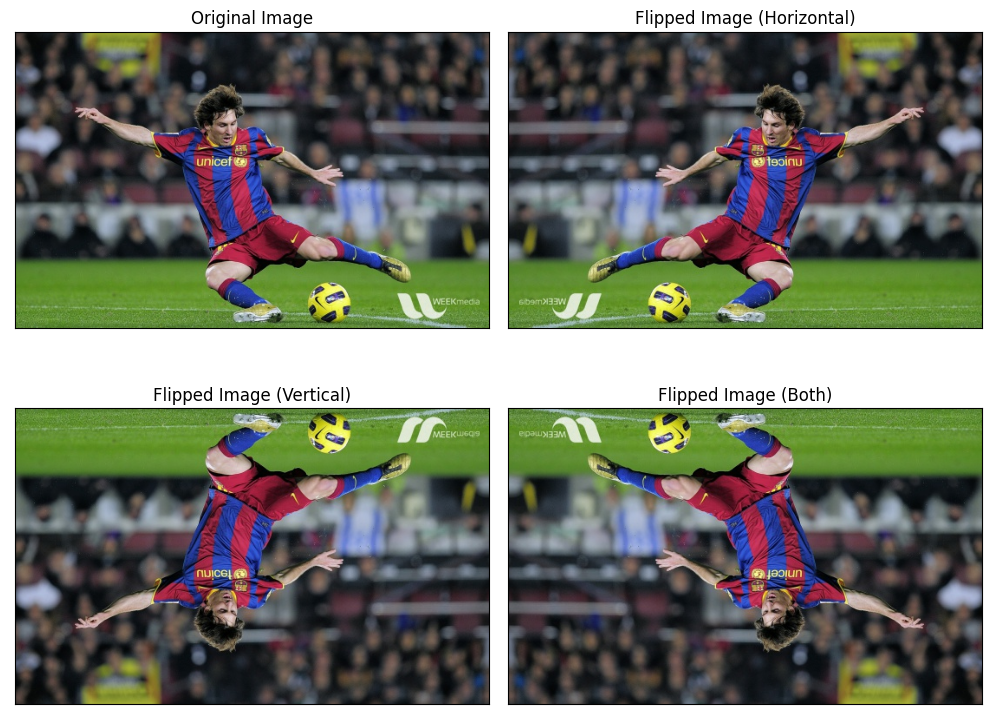

In [6]:
# Read in an image
img = cv.imread('../data/messi5.jpg')

# Get the number of rows and columns in the original image
rows, cols = img.shape[0:2]

# 1. Define the scale factors Sx and Sy, and shifts Tx and Ty.
# 2. Create a reflection (scale) matrix.
# 3. Transform the image using the reflection matrix

# Flip horizontally (around the y/vertical axis).
Sx = -1; Sy = 1; n_cols = cols; n_rows = 0
M = np.float32([
    [Sx,  0, n_cols],
    [ 0, Sy, n_rows]
])
img_horizontal = cv.warpAffine(img, M, (cols,rows))

# Flip vertically (around the x/horizontal axis).
Sx = 1; Sy = -1; n_cols = 0; n_rows = rows
M = np.float32([
    [Sx,  0, n_cols],
    [ 0, Sy, n_rows]
])
img_vertical = cv.warpAffine(img, M, (cols,rows))

# Flip around both axes.
Sx = -1; Sy = -1; n_cols = cols; n_rows = rows
M = np.float32([
    [Sx,  0, n_cols],
    [ 0, Sy, n_rows]
])
img_both = cv.warpAffine(img, M, (cols,rows))

# Plot the original image and the reflected (flipped) images
plt.figure(figsize=(10,8))

plt.subplot(221), plt.imshow(img[:,:,::-1]),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(222), plt.imshow(img_horizontal[:,:,::-1]),
plt.title("Flipped Image (Horizontal)"), plt.xticks([]), plt.yticks([])

plt.subplot(223), plt.imshow(img_vertical[:,:,::-1]),
plt.title("Flipped Image (Vertical)"), plt.xticks([]), plt.yticks([])

plt.subplot(224), plt.imshow(img_both[:,:,::-1]),
plt.title("Flipped Image (Both)"), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

OpenCV also provides a dedicated function [cv.flip()](https://docs.opencv.org/4.6.0/d2/de8/group__core__array.html#gaca7be533e3dac7feb70fc60635adf441) for flipping images.

`flip(src, flipCode[, dst]) -> dst`
- `src` is the source (input) image.
- `flipCode` decides what axis to flip the image around:
  - `0`: flip the image around the x axis (vertically).
  - `1`: flip the image around the y axis (horizontally).
  - `-1`: flip the image around both axes (vertically and horizontally).

The flipped image is returned in `dst`.

Let's look at an example.

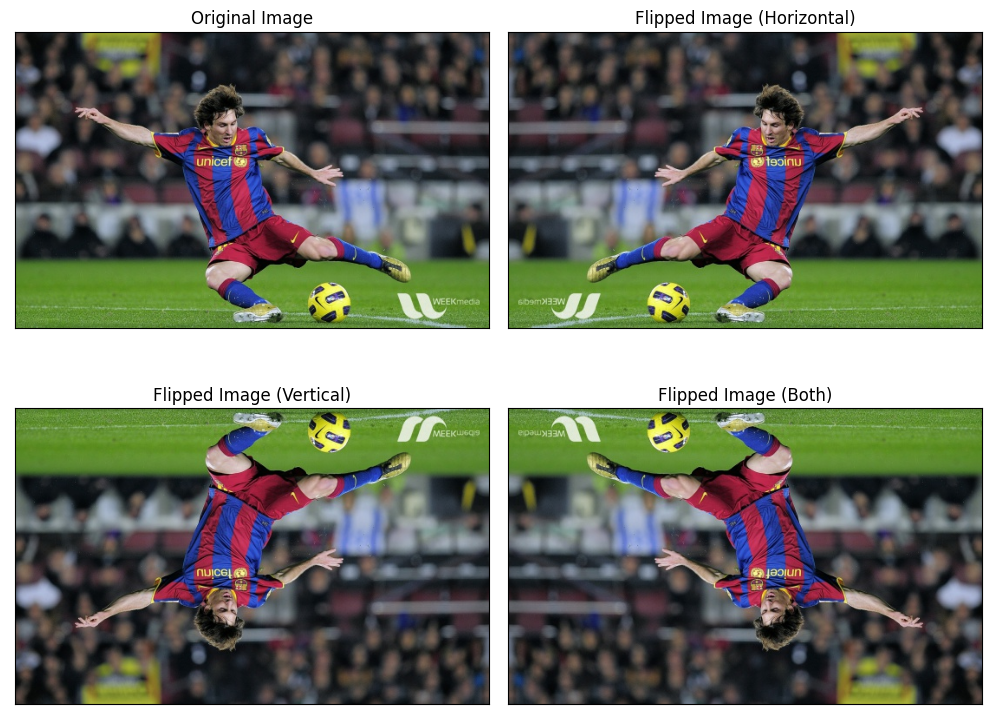

In [7]:
# Read in an image
img = cv.imread('../data/messi5.jpg')

# Flip the image.
# Here we are using various 'flipCodes' (second parameter):
# 0: flip the image around the x axis (vertically).
# 1: flip the image around the y axis (horizontally).
# -1: flip the image around both axes (vertically and horizontally).
img_vertical = cv.flip(img, 0)
img_horizontal = cv.flip(img, 1)
img_both = cv.flip(img, -1)

# Plot the original image and the flipped image
plt.figure(figsize=(10,8))

plt.subplot(221), plt.imshow(img[:,:,::-1]),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(222), plt.imshow(img_horizontal[:,:,::-1]),
plt.title("Flipped Image (Horizontal)"), plt.xticks([]), plt.yticks([])

plt.subplot(223), plt.imshow(img_vertical[:,:,::-1]),
plt.title("Flipped Image (Vertical)"), plt.xticks([]), plt.yticks([])

plt.subplot(224), plt.imshow(img_both[:,:,::-1]),
plt.title("Flipped Image (Both)"), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

### Shearing

Shearing displaces each point in an image in a fixed direction. It substitutes every point horizontally or vertically by a specific value in propotional to its x or y coordinates. An image can be sheared along the x axis, y axes or both. The amount of shearing along the x axis is determined by the shearing factor $Sh_x$. The amount of shearing along the y axis is determined by the shearing factor $Sh_y$.

The reflection matrix $M_A$ (for `cv.warpAffine()`) and $M_P$ (for `cv.warpPerspective()`) is defined as below:

$$
M_A =
\begin{bmatrix}
1 & Sh_x & 0\\
Sh_y & 1 & 0
\end{bmatrix}

\quad

M_P =
\begin{bmatrix}
1 & Sh_x & 0\\
Sh_y & 1 & 0\\
0 & 0 & 1
\end{bmatrix}
$$

Let's look at an example of shearing an image.

We will only use the $2x3$ matrix with `cv.warpAffine()` in the example, but we can also use the $3x3$ matrix with `cv.warpPerspective()`.

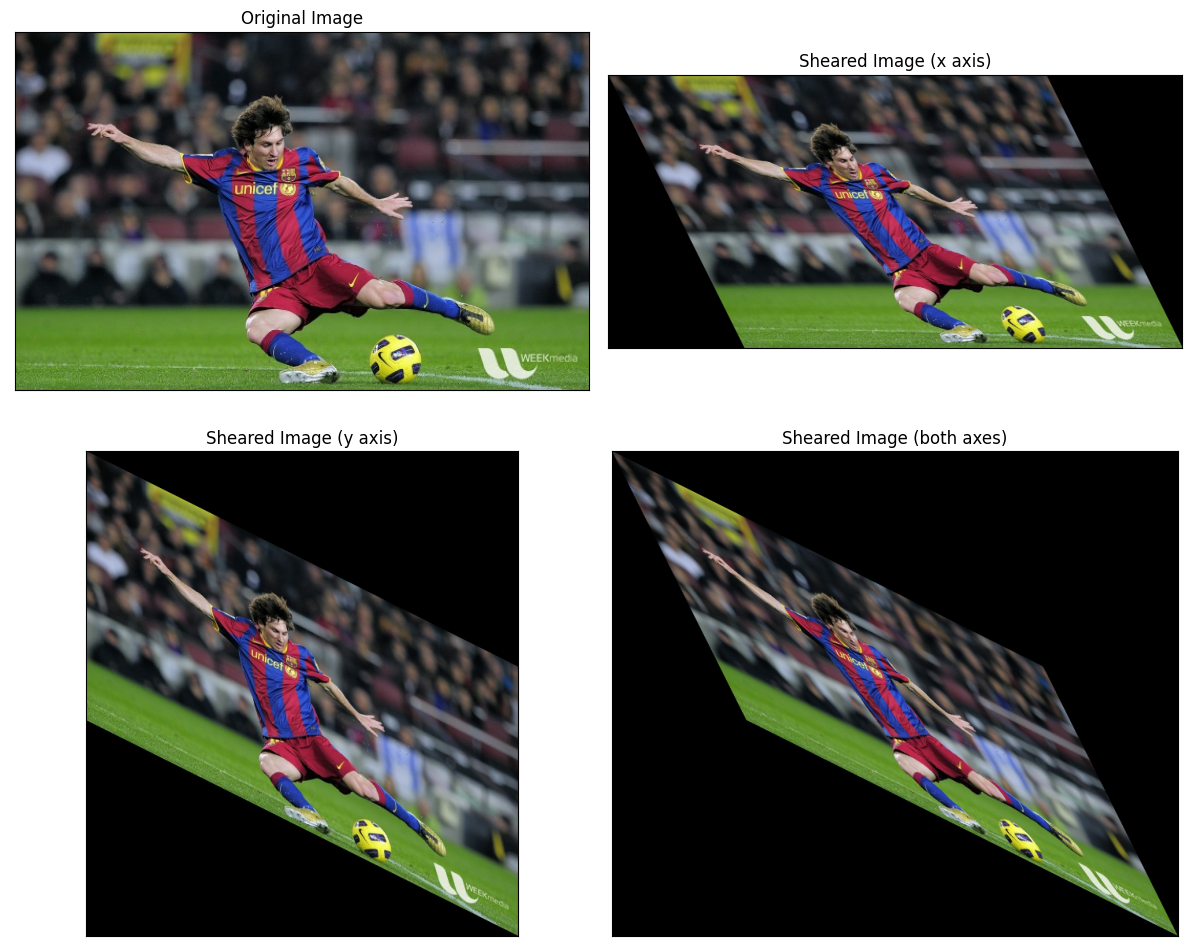

In [8]:
# Read in an image
img = cv.imread('../data/messi5.jpg')

# Get the number of rows and columns in the original image
rows, cols = img.shape[0:2]

# 1. Define the shering factors Shx and Shy.
# 2. Create a shearing matrix.
# 3. Transform the image using the shearing matrix

# Shear along the x axis
Shx = 0.5; Shy = 0
M = np.float32([
    [  1, Shx, 0],
    [Shy,   1, 0]
])
img_sheared_x = cv.warpAffine(img, M, (int(cols+rows*Shx),int(rows+cols*Shy)))

# Shear along the y axis
Shx = 0; Shy = 0.5
M = np.float32([
    [  1, Shx, 0],
    [Shy,   1, 0]
])
img_sheared_y = cv.warpAffine(img, M, (int(cols+rows*Shx),int(rows+cols*Shy)))

# Shear along both axes
Shx = 0.5; Shy = 0.5
M = np.float32([
    [  1, Shx, 0],
    [Shy,   1, 0]
])
img_sheared_x_y = cv.warpAffine(img, M, (int(cols+rows*Shx),int(rows+cols*Shy)))

# Plot the original image and the reflected (flipped) images
plt.figure(figsize=(12,10))

plt.subplot(221), plt.imshow(img[:,:,::-1]),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(222), plt.imshow(img_sheared_x[:,:,::-1]),
plt.title("Sheared Image (x axis)"), plt.xticks([]), plt.yticks([])

plt.subplot(223), plt.imshow(img_sheared_y[:,:,::-1]),
plt.title("Sheared Image (y axis)"), plt.xticks([]), plt.yticks([])

plt.subplot(224), plt.imshow(img_sheared_x_y[:,:,::-1]),
plt.title("Sheared Image (both axes)"), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

### Affine Transformation

All the transformations above are affine transformations, where all parallel lines in the original image are still parallel in the output image.

We can also create an affine transformation matrix from two set of points. To find the transformation matrix, we need three points from the input image and their corresponding locations in the output image. The OpenCV function [cv.getAffineTransform()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#ga8f6d378f9f8eebb5cb55cd3ae295a999) accepts the two sets of points as parameters and will return a 2x3 matrix, to be used with the [cv.warpAffine()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983) function.

`cv.getAffineTransform(src, dst) -> retval`
- `src` is the list of 3 points from the original image. 
- `dst` is the list of 3 points from the transformed image.

The transformation matrix that transforms any point in `src` to `dst` is returned in `retval`, which can be used with `cv.warpAffine()` to transform the whole original image.

Let's look at an example.

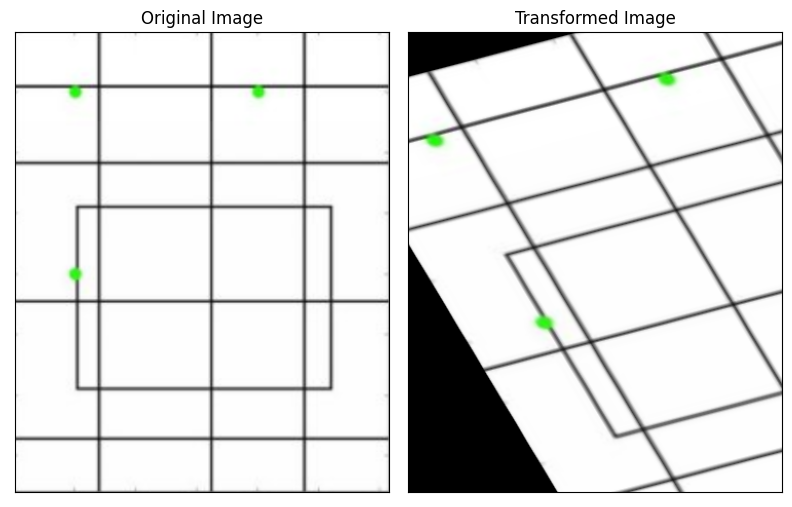

In [9]:
# Read in an image
img = cv.imread('../data/drawing.png')

# Get the number of rows and columns the image
rows, cols = img.shape[:2]

# Define three points in the original image, and the
# corresponding three points in the desired transformed image
pts_img = np.float32([[50,50], [200,50], [50,200]])
pts_transformed = np.float32([[10,100], [200,50], [100,250]])

# Create a transformation matrix that performs the affine
# transformation as defined by the two sets of points above
M = cv.getAffineTransform(pts_img, pts_transformed)

# Transform the image using the transformation matrix
img_transformed = cv.warpAffine(img, M, (cols,rows))

# Plot the original image and the transformed image
plt.figure(figsize=(8,8))

plt.subplot(121), plt.imshow(img[:,:,::-1]),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(img_transformed[:,:,::-1]),
plt.title("Transformed Image"), plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()

### Perspective Transformation

For a perspective transformation, you need a 3x3 transformation matrix. Straight lines in the original image will remain straight after the transformation.

We can create a perspective transformation matrix from two set of points. To find the transformation matrix, we need four points from the input image and their corresponding locations in the output image. The OpenCV function [cv.getPerspectiveTransform()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae) accepts the two sets of points as parameters and will return a 3x3 matrix, to be used with the [cv.warpPerspective()](https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87) function.

`cv.getPerspectiveTransform(src, dst]) -> retval`
- `src` is the list of 4 points from the original image.
- `dst` is the list of 4 points from the transformed image.

The transformation matrix that transforms any point in `src` to `dst` is returned in `retval`, which can be used with `cv.warpPerspective()` to transform the whole original image.

Let's look at an example.

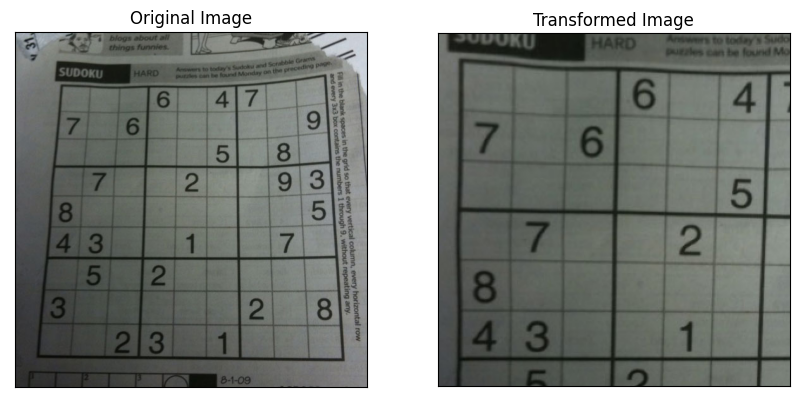

In [10]:
# Read in an image
img = cv.imread('../data/sudoku.png')

# Get the number of rows and columns
rows, cols = img.shape[:2]

# Define four points in the original image, and the
# corresponding four points in the desired transformed image
pts1 = np.float32([[56,65], [368,52], [28,387], [389,390]])
pts2 = np.float32([[0,0], [300,0], [0,300], [300,300]])

# Create a transformation matrix that performs the perspective
# transformation as defined by the two sets of points above
M = cv.getPerspectiveTransform(pts1, pts2)

# Transform the image using the transformation matrix
# and the 'warpPerspective()' function
img_transformed = cv.warpPerspective(img, M, (300,300))

# Plot the original image and the transformed image
plt.figure(figsize=(10,10))

plt.subplot(121), plt.imshow(img[:,:,::-1]),

plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(122), plt.imshow(img_transformed[:,:,::-1]),
plt.title("Transformed Image"),  plt.xticks([]), plt.yticks([])

plt.show()

### Other image augmentation techniques

There are other traditional ways to augment images, such as tweeking the color channel levels, brightness, adding noise, and cropping the images.

Let's look at a few examples below.

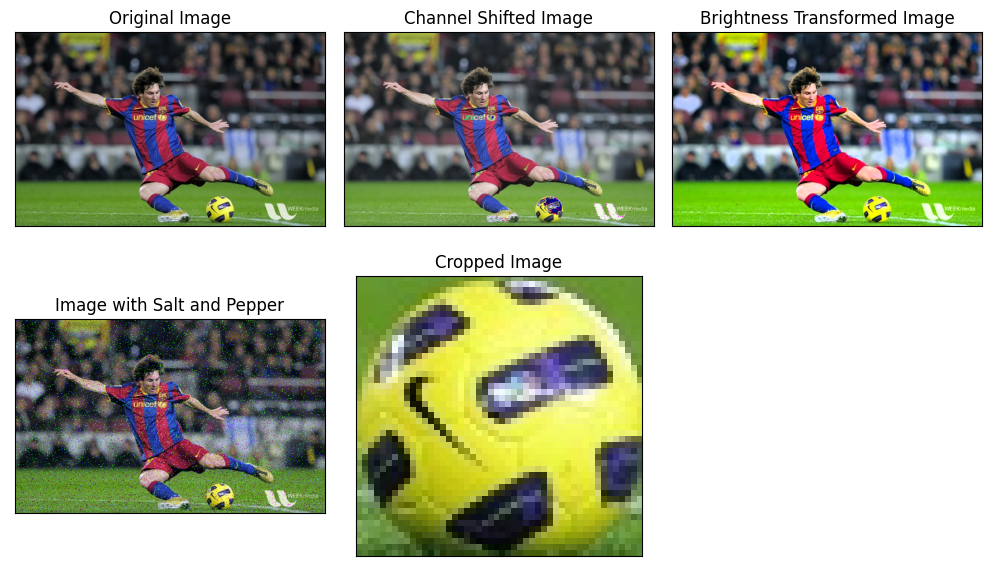

In [11]:
# Define a function for shifting color channel values randomly
def channel_shift(img, value):
    img = img.copy()
    value = int(np.random.uniform(-value, value))
    img = img + value
    img[img > 255] = 255
    img[img < 0] = 0
    img[:,:,:][img[:,:,:]>255] = 255
    img[:,:,:][img[:,:,:]<0] = 0
    return img.astype(np.uint8)

# Define a function for tweeking the brightness randomly
def brightness(img, low, high):
    img = img.copy()
    value = np.random.uniform(low, high)
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255] = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    return img

# Define a function for randomly adding noise to an image
def add_salt_and_pepper(img, pixel_ratio):
    img = img.copy()
    n_pixels = int(np.ceil(pixel_ratio * img.size))
    salt_coords = tuple([np.random.randint(0, i-1, n_pixels) for i in img.shape])
    pepper_coords = tuple([np.random.randint(0, i-1, n_pixels) for i in img.shape])
    img[salt_coords] = 255
    img[pepper_coords] = 0
    return img

np.random.seed(30)

# Read in image
img = cv.imread('../data/messi5.jpg')

# Augment images
img_channel_shifted = channel_shift(img, 60)
img_brightness = brightness(img, 0.5, 3)
img_salt_and_pepper = add_salt_and_pepper(img, 0.025)
img_cropped = img[289:336, 338:386]

# Plot the original image and the augmented images
plt.figure(figsize=(10,6))

plt.subplot(231), plt.imshow(img[:,:,::-1]),
plt.title("Original Image"), plt.xticks([]), plt.yticks([])

plt.subplot(232), plt.imshow(img_channel_shifted[:,:,::-1]),
plt.title("Channel Shifted Image"),  plt.xticks([]), plt.yticks([])

plt.subplot(233), plt.imshow(img_brightness[:,:,::-1]),
plt.title("Brightness Transformed Image"),  plt.xticks([]), plt.yticks([])

plt.subplot(234), plt.imshow(img_salt_and_pepper[:,:,::-1]),
plt.title("Image with Salt and Pepper"),  plt.xticks([]), plt.yticks([])

plt.subplot(235), plt.imshow(img_cropped[:,:,::-1]),
plt.title("Cropped Image"),  plt.xticks([]), plt.yticks([])

plt.tight_layout(pad=1.0)
plt.show()